<a href="https://colab.research.google.com/github/nimiw0821/1012-Natural-Language-Understanding/blob/master/machine_reading_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiDaf (paper)
https://arxiv.org/pdf/1611.01603.pdf

In [0]:
! git clone https://github.com/williamFalcon/squad.git

Cloning into 'squad'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 47 (delta 5), reused 3 (delta 0), pack-reused 33
Unpacking objects: 100% (47/47), done.


In [0]:
! cd squad/ && git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/williamFalcon/squad
   1ad045b..aae0450  master     -> origin/master
Updating 1ad045b..aae0450
Fast-forward
 layers.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [0]:
! ls squad

args.py  environment.yml  LICENSE    README.md	setup.py  train.py
data	 layers.py	  models.py  save	test.py   util.py


In [0]:
!pip install pytorch-lightning

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 5.4MB 6.4MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 17.3MB 53.8MB/s 
     |████████████████████████████████| 3.9MB 27.0MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-0.5.3.2-cp36-none-any.whl size=76809 sha256=ebdc177f15cf2d457696b29892a6e7c051064c2720a1972a090feda1da320cf8
  Stored in directory: /root/.cache/pip/wheels/11/15/89/461396b8cb92adba1162a289db63c90eb31be34bceabbec77e
  Created wheel for test-tube: filename=test_tube-0.7.3-cp36-none-any.whl size=25049 sha256=2572050a5d0a5346a1813897486f9fb0e42ed6710cdcfdf868d75aecc4b1f0e3
  Stored in directory: /root/.cache/pip/wheels/17/1e/50/6f5b5212af4108ab6055a9c6a869550c8631270317219a0ea8
Successfully built pytorch-lightning test-tube
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 

In [0]:
! pip install ujson

     |████████████████████████████████| 194kB 2.6MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68033 sha256=07b3b12f2f0567845a455131819fa67a6d502a95366a9b096c8d0312963944ea
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [0]:
! cd squad/ && python setup.py

glove.840B.300d.zip: 2.18GB [16:57, 2.14MB/s]                
Unzipping GloVe word vectors...
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Pre-processing train examples...
100% 442/442 [01:28<00:00,  5.01it/s]
130319 questions in total
Pre-processing word vectors...
2196018it [02:43, 13399.84it/s]                 
88744 / 107454 tokens have corresponding word embedding vector
Pre-processing char vectors...
1374 tokens have corresponding char embedding vector
Pre-processing dev examples...
100% 16/16 [00:03<00:00,  4.42it/s]
6078 questions in total
Converting train examples to indices...
130319it [00:39, 3315.01it/s]
tcmalloc: large alloc 3326009344 bytes == 0x137fcc000 @  0x7f61785c61e7 0x7f61760cfca1 0x7f6176134778 0x7f6176137ec0 0x7f6176138435 0x7f61761d

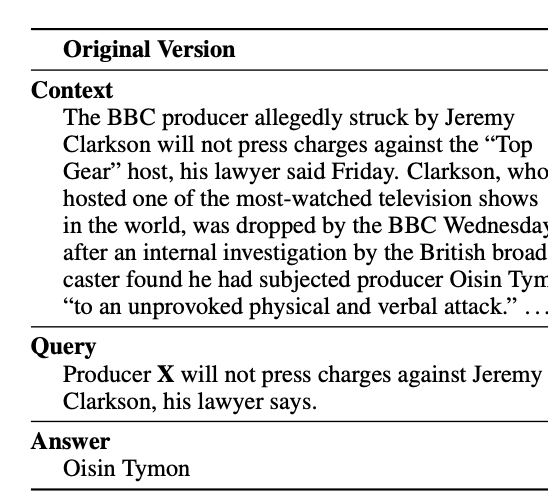

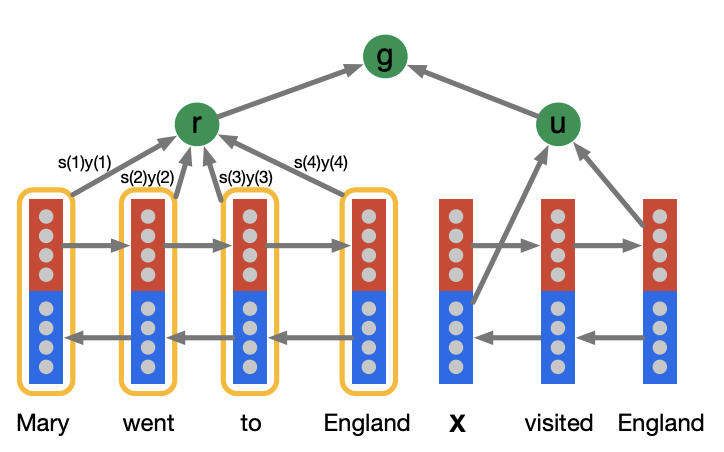

In [0]:
seed = 224
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.utils.data as data

from squad.util import collate_fn, SQuAD
from collections import OrderedDict
from json import dumps
from tqdm import tqdm
from ujson import load as json_load
import pytorch_lightning as pl

from squad import layers, util
import os

DIR = os.getcwd()

---  
## Data (SQuAD)

For this exercise we'll use SQuAD

Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

In [0]:
train_path = os.path.join(DIR, 'squad/data/train.npz')
train_loader = data.DataLoader(SQuAD(train_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)


In [0]:
dev_path = os.path.join(DIR, 'squad/data/dev.npz')
dev_loader = data.DataLoader(SQuAD(dev_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)

In [0]:
test_path = os.path.join(DIR, 'squad/data/test.npz')
test_loader = data.DataLoader(SQuAD(test_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)

--- 
## Model

Here we'll break down the model into 5 components and examine each:
1. Embedding
2. RNN Encoder
3. Attention mechanism
4. A second encoder
5. The output layer used for QA

### Hyperparams

In [0]:
hidden_size = 64
drop_p = 0.2

---
#### Embedding   
Embedding layer used by BiDAF, without the character-level component.
Word-level embeddings are further refined using a 2-layer Highway Encoder (see `HighwayEncoder` class for details).

Embedding + projections below

```
self.embed = nn.Embedding.from_pretrained(word_vectors)
self.proj = nn.Linear(word_vectors.size(1), hidden_size, bias=False)
self.hwy = HighwayEncoder(2, hidden_size)
```

In [0]:
# load pretrained vectors
globe = os.path.join(DIR, 'squad/data/word_emb.json')
word_vectors = util.torch_from_json(globe)

# load into embedding layer
emb = layers.Embedding(word_vectors=word_vectors, 
                       hidden_size=hidden_size, 
                       drop_prob=drop_p)

---
#### RNN Encoder   
General-purpose layer for encoding a sequence using a bidirectional RNN.
    Encoded output is the RNN's hidden state at each position, which
    has shape (batch_size, seq_len, hidden_size * 2).

```
self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           bidirectional=True,
                           dropout=drop_prob if num_layers > 1 else 0.)
```

In [0]:
enc = layers.RNNEncoder(input_size=hidden_size, 
                        hidden_size=hidden_size, 
                        num_layers=1,
                        drop_prob=drop_p)

---
#### Attention mechanism   
 
 Bidirectional attention computes attention in two directions:
    The context attends to the query and the query attends to the context.
    The output of this layer is the concatenation of [context, c2q_attention,
    context * c2q_attention, context * q2c_attention]. This concatenation allows
    the attention vector at each timestep, along with the embeddings from
    previous layers, to flow through the attention layer to the modeling layer.

In this model, the main idea is bidirectional Flow: ie: context attends to question and question attends to context.

In [0]:
att = layers.BiDAFAttention(hidden_size=2 * hidden_size, drop_prob=drop_p)

---
#### Second encoder
This encoder integrates information of the context and question together.

```
self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True,
                           bidirectional=True,
                           dropout=drop_prob if num_layers > 1 else 0.)
```

In [0]:
mod = layers.RNNEncoder(input_size=8 * hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=2,
                                     drop_prob=drop_p)

---
#### Output layer

Computes a linear transformation of the attention and modeling
    outputs, then takes the softmax of the result to get the start pointer.
    A bidirectional LSTM is then applied the modeling output to produce `mod_2`.
    A second linear+softmax of the attention output and `mod_2` is used
    to get the end pointer.

Calculate probability over sequence to calculate the probability of a start and end token.

In [0]:
out = layers.BiDAFOutput(hidden_size=hidden_size,
                                      drop_prob=drop_p)

---
#### Data explore

In [0]:
for batch in train_loader:
    break

cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids = batch 

In [0]:
# context idxs
print('cw_idxs', cw_idxs.shape)
print('cc_idxs', cc_idxs.shape)
print('qw_idxs', qw_idxs.shape)
print('qc_idxs', qc_idxs.shape)
print('y1', y1.shape)
print('y2', y2.shape)
print('ids', ids.shape)

cw_idxs torch.Size([32, 221])
cc_idxs torch.Size([32, 221, 16])
qw_idxs torch.Size([32, 20])
qc_idxs torch.Size([32, 20, 16])
y1 torch.Size([32])
y2 torch.Size([32])
ids torch.Size([32])


#### Forward pass

In [0]:
# inputs are the context_idxs and context_char_idxs

# masks
c_mask = torch.zeros_like(cw_idxs) != cw_idxs
q_mask = torch.zeros_like(qw_idxs) != qw_idxs

In [0]:
# get sequence length
c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)
print(c_len.shape, q_len.shape)

torch.Size([32]) torch.Size([32])


In [0]:
# embed
# (b, c_len, 1) -> (b, c_len, emb_size)
# (b, c_len, 1) -> (b, c_len, emb_size)
c_emb = emb(cw_idxs)
q_emb = emb(qw_idxs)

print(c_emb.shape, q_emb.shape)

torch.Size([32, 221, 64]) torch.Size([32, 20, 64])


In [0]:
# encode each
# (b, c_len, emb_size) -> (b, c_len, 2 * hidden_size)

c_enc = enc(c_emb, c_len)
q_enc = enc(q_emb, q_len)
print(c_enc.shape, q_enc.shape)

torch.Size([32, 221, 128]) torch.Size([32, 20, 128])


In [0]:
att_out = att(c_enc, q_enc, c_mask, q_mask)    # (batch_size, c_len, 8 * hidden_size)
print(att_out.shape)

torch.Size([32, 221, 512])


In [0]:
mod_out = mod(att_out, c_len)
full_out = out(att_out, mod_out, c_mask)

---  
#### Loss
The loss function is the sum of the negative log-likelihood (cross-entropy) loss for the start and
end locations.

In [0]:
log_p1, log_p2 = full_out
loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)

In [0]:
print(loss)

tensor(9.4978, grad_fn=<AddBackward0>)


---
### Full system
Here's the full system which we'll fit to the data now

In [0]:
class BiDAF(pl.LightningModule):
    def __init__(self, word_vectors, hidden_size, drop_prob=0.):
        super(BiDAF, self).__init__()
        self.emb = layers.Embedding(word_vectors=word_vectors,
                                    hidden_size=hidden_size,
                                    drop_prob=drop_prob)

        self.enc = layers.RNNEncoder(input_size=hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=1,
                                     drop_prob=drop_prob)

        self.att = layers.BiDAFAttention(hidden_size=2 * hidden_size,
                                         drop_prob=drop_prob)

        self.mod = layers.RNNEncoder(input_size=8 * hidden_size,
                                     hidden_size=hidden_size,
                                     num_layers=2,
                                     drop_prob=drop_prob)

        self.out = layers.BiDAFOutput(hidden_size=hidden_size,
                                      drop_prob=drop_prob)

    def loss(self, full_out, y1, y2):
        log_p1, log_p2 = full_out
        loss = F.nll_loss(log_p1, y1.cuda(0)) + F.nll_loss(log_p2, y2.cuda(0))
        return loss

# [9, 8, 7, 0, 0] (3)
# [9, 0,0,0,0] (1)

    def forward(self, cw_idxs, qw_idxs):
        c_mask = torch.zeros_like(cw_idxs) != cw_idxs
        q_mask = torch.zeros_like(qw_idxs) != qw_idxs
        c_len, q_len = c_mask.sum(-1), q_mask.sum(-1)

        # fancy embedding
        c_emb = self.emb(cw_idxs)         
        q_emb = self.emb(qw_idxs)       

        # encode the sequence (each one)
        c_enc = self.enc(c_emb, c_len)    
        q_enc = self.enc(q_emb, q_len)

        # context attends question
        # and question attends context
        att = self.att(c_enc, q_enc,
                       c_mask, q_mask)

        # integrate information of context and question
        mod = self.mod(att, c_len)       

        # find span
        out = self.out(att, mod, c_mask) 
        return out
        
        
    def training_step(self, batch, batch_nb):
        cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids = batch 
        out = self.forward(cw_idxs, qw_idxs)
        loss = self.loss(out, y1, y2)
        return {
            'loss': loss,
            'log': {'train_loss': loss},
            'progress_bar': {'train_loss': loss}
        }
    
    def configure_optimizers(self):
        optimizer = optim.Adadelta(self.parameters(), 0.5,
                               weight_decay=0)
        scheduler = sched.LambdaLR(optimizer, lambda s: 1.)  # Constant LR
        return [optimizer], [scheduler]

    @pl.data_loader
    def train_dataloader(self):
        # REQUIRED
        return train_loader
    
    @pl.data_loader
    def val_dataloader(self):
        # OPTIONAL
        return dev_loader

    @pl.data_loader
    def test_dataloader(self):
        # OPTIONAL
        return test_loader

### Fit

In [0]:
model = BiDAF(word_vectors, 512, 0.2)

In [0]:
trainer = pl.Trainer(gpus=1)

In [0]:
trainer.fit(model)

Epoch 1:  27%|██▋       | 1125/4245 [07:43<21:55,  2.37batch/s, batch_nb=1124, gpu=0, loss=6.369, train_loss=6.77, v_nb=6]

---   
#### Prediction
To predict, we discretize the soft predictions of the model to get start and end indices. We choose
the pair (i, j) of indices that maximizes pstart(i) · pend(j) subject to i ≤ j and j − i + 1 ≤ Lmax,
where Lmax is a hyperparameter which sets the maximum length of a predicted answer. We set
Lmax to 15 by default.

In [0]:
def evaluate(model, data_loader, device, eval_file, max_len, use_squad_v2):
    nll_meter = util.AverageMeter()

    model.eval()
    pred_dict = {}
    with open(eval_file, 'r') as fh:
        gold_dict = json_load(fh)
    with torch.no_grad(), \
            tqdm(total=len(data_loader.dataset)) as progress_bar:
        for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
            # Setup for forward
            cw_idxs = cw_idxs.to(device)
            qw_idxs = qw_idxs.to(device)
            batch_size = cw_idxs.size(0)

            # Forward
            log_p1, log_p2 = model(cw_idxs, qw_idxs)
            y1, y2 = y1.to(device), y2.to(device)
            loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
            nll_meter.update(loss.item(), batch_size)

            # Get F1 and EM scores
            p1, p2 = log_p1.exp(), log_p2.exp()
            starts, ends = util.discretize(p1, p2, max_len, use_squad_v2)

            # Log info
            progress_bar.update(batch_size)
            progress_bar.set_postfix(NLL=nll_meter.avg)

            preds, _ = util.convert_tokens(gold_dict,
                                           ids.tolist(),
                                           starts.tolist(),
                                           ends.tolist(),
                                           use_squad_v2)
            pred_dict.update(preds)

    model.train()

    results = util.eval_dicts(gold_dict, pred_dict, use_squad_v2)
    results_list = [('NLL', nll_meter.avg),
                    ('F1', results['F1']),
                    ('EM', results['EM'])]
    if use_squad_v2:
        results_list.append(('AvNA', results['AvNA']))
    results = OrderedDict(results_list)

    return results, pred_dict

In [0]:
# TODO: how to ensure second logit is larger